Hallo

In [1]:
import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyspark.sql.functions as Func
from data import get_rating_matrix, get_interactions, get_job_data, get_job_interactions_matrix
#from biasedALS import ALS


# Bias is a function of time.


In [4]:
lookback = 90
rating_matrix = pd.read_csv('./data/ratings-%s-days.csv' % lookback)
rating_matrix_filtered = pd.read_csv('./data/ratings-filtered-%s-days.csv' % lookback)

item_feature_df = pd.read_csv('./data/item_feature-%s-days.csv' %lookback)
item_feature_df_filtered = pd.read_csv('./data/item_feature-filtered-%s-days.csv' %lookback)

job_interaction_matrix = pd.read_csv('./data/job_interactions-%s-days.csv' %lookback)
interactions = pd.read_csv('./data/interactions-%s-days.csv' %lookback)
interactions_events = pd.read_csv('./data/interactions_events-%s-days.csv' %lookback)

In [13]:
import numpy as np

# user_job_matrix = (interactions_events.groupby(
#     interactions_events['userId']).agg(
#         {
#         'click': 'sum',
#         'favorite_event': 'sum',
#         'applyForPosition_event': 'sum',
#         }
#         ).reset_index())

# user_job_matrix['interactions'] = user_job_matrix[['click', 'favorite_event', 'applyForPosition_event']].sum(axis=1)
# relevant_users = user_job_matrix[user_job_matrix.interactions >= 1]
# matching_id = interactions_events.userId.isin(relevant_users.userId)  # This returns a boolean Series of whether values match or not

# interaction_events_with_interacted_users = interactions_events.loc[matching_id, :]
# job_interaction_matrix_with_on_interacted_users  = get_job_interactions_matrix(job_data, interaction_events_with_interacted_users)

# %%
#all_user_interactions_with_jobs = interactions_with_jobs[interactions_with_jobs.userId.notna()]

# %%
#all_user_interactions_with_jobs
# %%
recommendations = interactions_events.itemId.value_counts().rename_axis('itemId').reset_index(name='recommendations')
recommendations

       Unnamed: 0  itemId  click  favorite_event  applyForPosition_event  \
15129       15129   15129  472.0             6.0                    14.0   

      county                                           industry job_sector  \
15129  Viken  ['INDUSTRY_CONSTRUCTION', 'INDUSTRY_OIL_AND_GA...    PRIVATE   

         state applicationdeadline            published  recommendations  \
15129  EXPIRED                 NaN  2022-04-28 13:11:00          12516.0   

       amount_deadline_days  interactions  
15129                   0.0         492.0  


TypeError: 'datetime.date' object cannot be interpreted as an integer

In [19]:
from datetime import date, timedelta
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

       Unnamed: 0  itemId  click  favorite_event  applyForPosition_event  \
15129       15129   15129  472.0             6.0                    14.0   

      county                                           industry job_sector  \
15129  Viken  ['INDUSTRY_CONSTRUCTION', 'INDUSTRY_OIL_AND_GA...    PRIVATE   

         state applicationdeadline            published  recommendations  \
15129  EXPIRED                 NaN  2022-04-28 13:11:00          12516.0   

       amount_deadline_days  interactions  
15129                   0.0         492.0  
15129
EXPIRED
[472.] [6.] [14.]


C:\Users\perni\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
C:\Users\perni\AppData\Local\Temp/ipykernel_18580/1389771469.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dict[date] = 'Day ' + str(index)
C:\Users\perni\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

<AxesSubplot:xlabel='days', ylabel='Interaction Amount'>

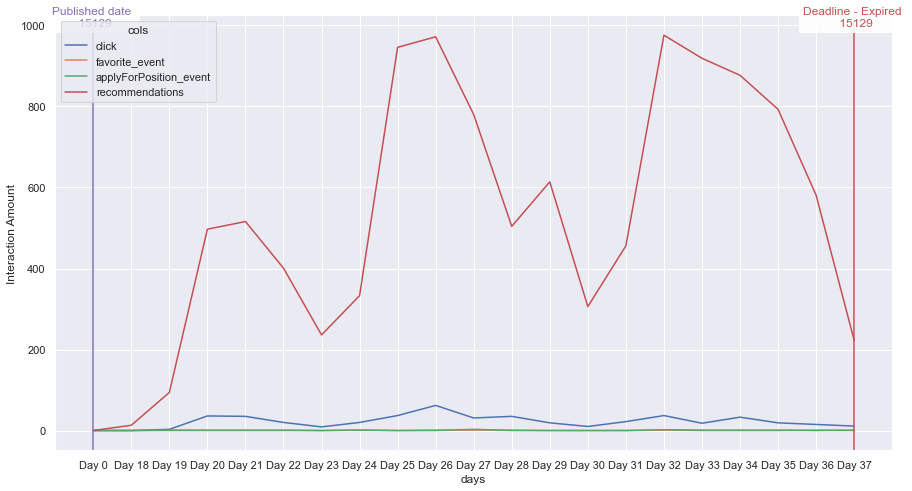

In [56]:
from datetime import datetime
def get_time_interaction_graph_for_item(itemId):


    df = interactions_events[interactions_events.itemId == itemId]
    df = df.append({'timestamp': job_interaction_matrix[job_interaction_matrix.itemId == itemId].applicationdeadline.values[0]}, ignore_index=True)
    print(job_interaction_matrix[job_interaction_matrix.itemId == itemId])
    if np.isnan( job_interaction_matrix[job_interaction_matrix.itemId == itemId].applicationdeadline.values[0]):
        deadline = [datetime.today().strftime('%Y-%m-%d')]
        desc = 'Soon as Possible \n %s' % itemId

        expired_date = deactivated_date = None

        if job_interaction_matrix[job_interaction_matrix.itemId == itemId].state.values[0] == 'EXPIRED':
            expired_date = pd.to_datetime(interactions_events[interactions_events.itemId == itemId].sort_values(by='timestamp').tail(1).timestamp).dt.date.values[0]
        if job_interaction_matrix[job_interaction_matrix.itemId == itemId].state.values[0] == 'DEACTIVATED':
            deactivated_date = pd.to_datetime(interactions_events[interactions_events.itemId == itemId].sort_values(by='timestamp').tail(1).timestamp).dt.date.values[0]


        if expired_date:
            deadline = [expired_date]
            desc = 'Deadline - Expired \n %s' % itemId

        if deactivated_date:
            deadline = [deactivated_date]
            desc = 'Deactivated \n %s' % itemId
    else:
        deadline = job_interaction_matrix[job_interaction_matrix.itemId == itemId].applicationdeadline.values[0]
        desc = 'Deadline \n %s' % itemId

    df2 = pd.DataFrame({'timestamp': [job_interaction_matrix[job_interaction_matrix.itemId == itemId].published.values[0]]})
    df = df2.append(df)
    df = df.reset_index(drop=True)
    times = df.groupby(pd.to_datetime(df['timestamp']).dt.date).agg({
        'click': 'sum',
        'favorite_event': 'sum',
        'applyForPosition_event': 'sum',
        'userId':  lambda x: x.nunique()
    }).reset_index()

    times = times.rename(columns={'userId': 'recommendations'})

    start_date = times.head(1).timestamp.values[0]
    end_date = pd.to_datetime(interactions_events[interactions_events.itemId == itemId].sort_values(by='timestamp').tail(1).timestamp).dt.date.values[0] if np.isnan(job_interaction_matrix[job_interaction_matrix.itemId == itemId].applicationdeadline.values[0]) else  pd.to_datetime(job_interaction_matrix[job_interaction_matrix.itemId == itemId].applicationdeadline).dt.date.values[0]
    day_dict = times.head(1).timestamp

    for index in range(int((end_date + timedelta(days=1) - start_date).days)):
        date =  start_date + timedelta(days=index)
        day_dict[date] = 'Day ' + str(index)

    times['days'] = times.timestamp.map(day_dict)

    label_list = [
       (day_dict[times.head(1).timestamp.values[0]], 'Published date \n %s' % itemId, 'm'),
       (day_dict[deadline].values[0],  desc, 'r')
    ]


    df2 = times[['click', 'favorite_event', 'applyForPosition_event', 'days', 'recommendations']]
    dfm2 = df2.melt('days', var_name='cols', value_name='vals')

    graph = sns.lineplot(data=dfm2, x='days', y='vals', hue='cols')
    graph.set(ylabel='Interaction Amount')
    sns.set(rc = {'figure.figsize':(15,8)})


    ax = plt.gca()

    for date_point, label, clr in label_list:
        plt.axvline(x=date_point, color=clr)
        plt.text(date_point, ax.get_ylim()[1]-4, label,
                horizontalalignment='center',
                verticalalignment='center',
                color=clr,
                bbox=dict(facecolor='white', alpha=0.9))
    print(itemId)
    print(job_interaction_matrix[job_interaction_matrix.itemId == itemId].state.values[0])
    print(job_interaction_matrix[job_interaction_matrix.itemId == itemId].click.values, job_interaction_matrix[job_interaction_matrix.itemId == itemId].favorite_event.values, job_interaction_matrix[job_interaction_matrix.itemId == itemId].applyForPosition_event.values)

    return graph, times



# %%
graph, times = get_time_interaction_graph_for_item(15129 )
graph

       Unnamed: 0  itemId  click  favorite_event  applyForPosition_event  \
15129       15129   15129  472.0             6.0                    14.0   

      county                                           industry job_sector  \
15129  Viken  ['INDUSTRY_CONSTRUCTION', 'INDUSTRY_OIL_AND_GA...    PRIVATE   

         state applicationdeadline            published  recommendations  \
15129  EXPIRED                 NaN  2022-04-28 13:11:00          12516.0   

       amount_deadline_days  interactions  
15129                   0.0         492.0  
15129
EXPIRED
[472.] [6.] [14.]
       Unnamed: 0  itemId  click  favorite_event  applyForPosition_event  \
26976       26976   26976  387.0             5.0                     7.0   

                     county                                       industry  \
26976  Vestfold og Telemark  ['INDUSTRY_INTERNET_SERVICES', 'INDUSTRY_IT']   

      job_sector    state applicationdeadline            published  \
26976    PRIVATE  EXPIRED            

C:\Users\perni\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
C:\Users\perni\AppData\Local\Temp/ipykernel_18580/1389771469.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dict[date] = 'Day ' + str(index)
C:\Users\perni\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

KeyError: "None of [Index(['2022-07-01'], dtype='object')] are in the [index]"

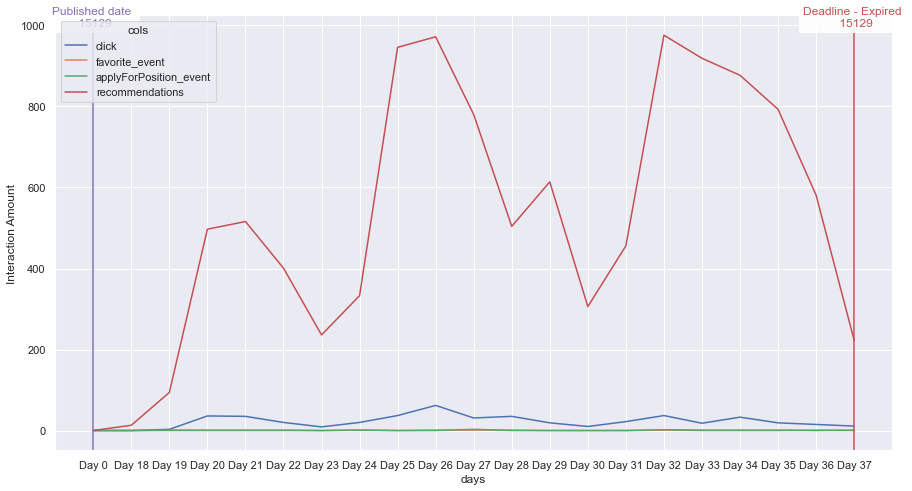

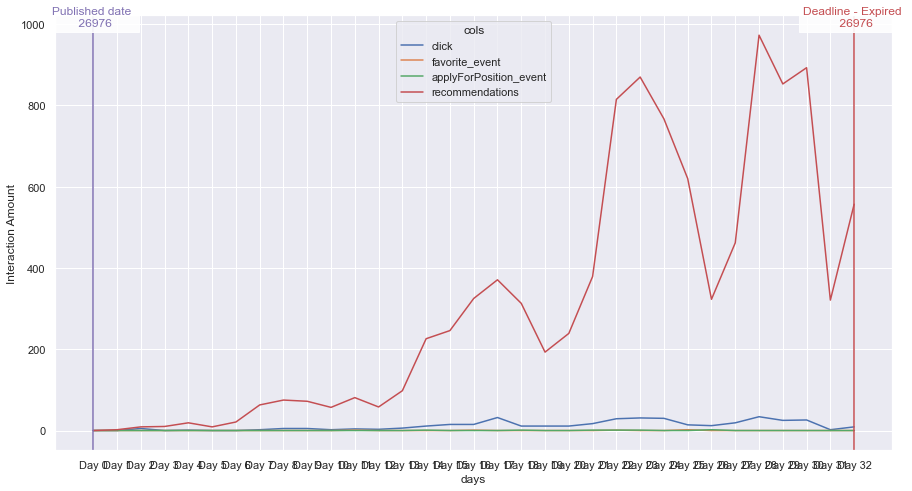

<Figure size 1080x576 with 0 Axes>

In [57]:
job_interaction_matrix.sort_values(by='interactions', ascending=False).head(10)
# %%
for index, item in enumerate(job_interaction_matrix.sort_values(by='interactions', ascending=False).head(10).itemId):
    plt.figure(index)
    get_time_interaction_graph_for_item(item)

# %%
for index, item in enumerate(job_interaction_matrix[job_interaction_matrix.state == 'ACTIVATED'].sort_values(by='interactions', ascending=False).head(10).itemId):
    plt.figure(index)
    get_time_interaction_graph_for_item(item)

       Unnamed: 0  itemId  click  favorite_event  applyForPosition_event  \
15129       15129   15129  472.0             6.0                    14.0   

      county                                           industry job_sector  \
15129  Viken  ['INDUSTRY_CONSTRUCTION', 'INDUSTRY_OIL_AND_GA...    PRIVATE   

         state applicationdeadline            published  recommendations  \
15129  EXPIRED                 NaN  2022-04-28 13:11:00          12516.0   

       amount_deadline_days  interactions  
15129                   0.0         492.0  
     timestamp  click  favorite_event  applyForPosition_event  recommendations
0   2022-04-28    0.0             0.0                     0.0                0
1   2022-05-16    0.0             0.0                     0.0               13
2   2022-05-17    3.0             0.0                     1.0               94
3   2022-05-18   36.0             0.0                     1.0              497
4   2022-05-19   35.0             0.0                 

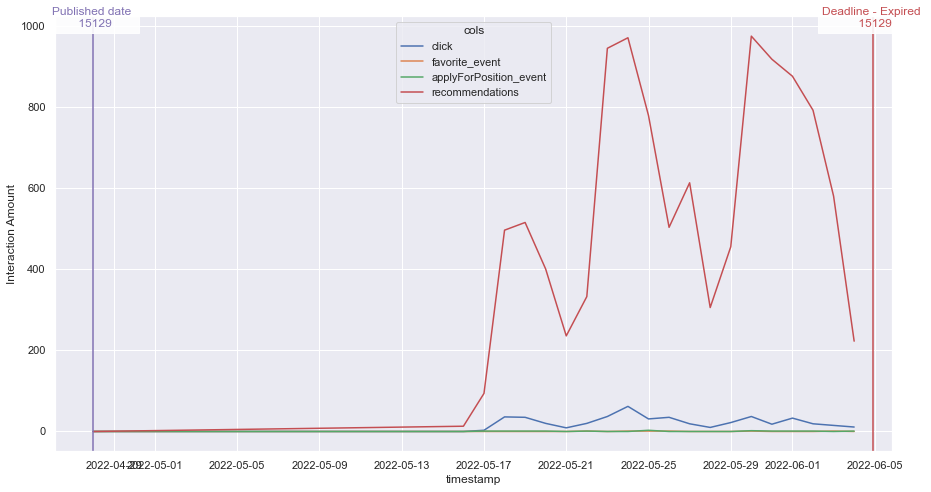

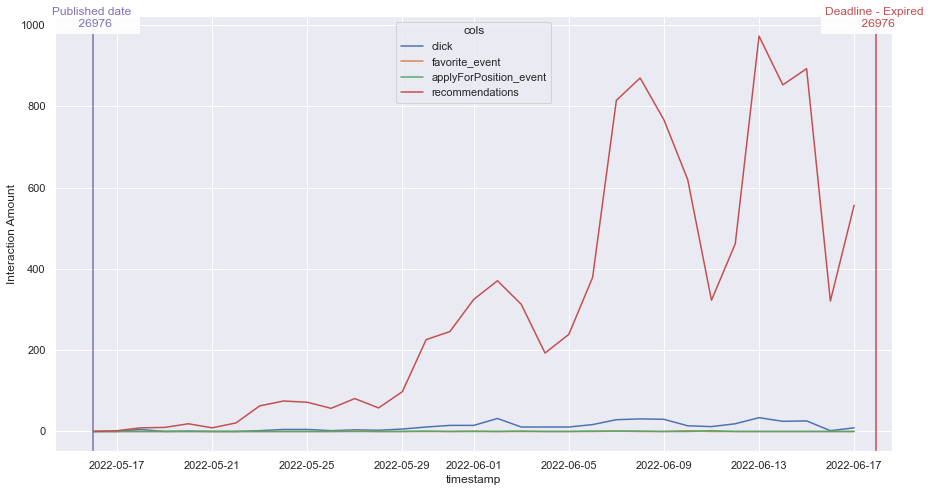

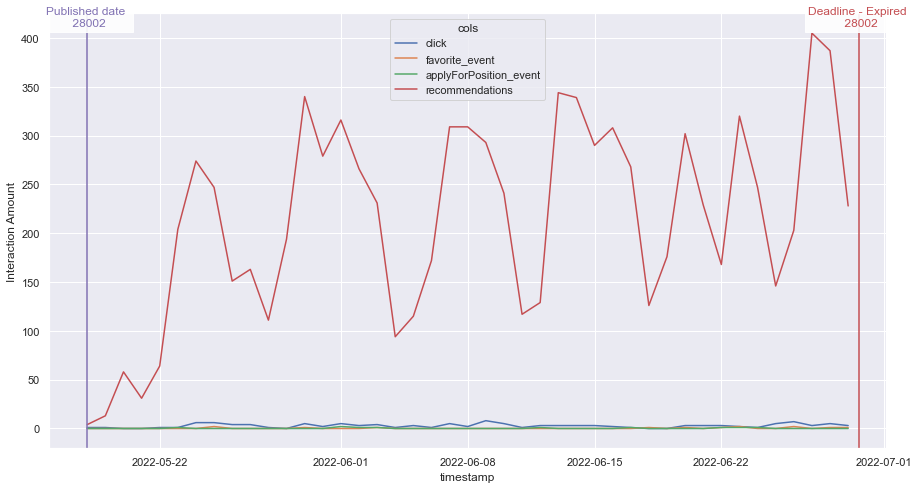

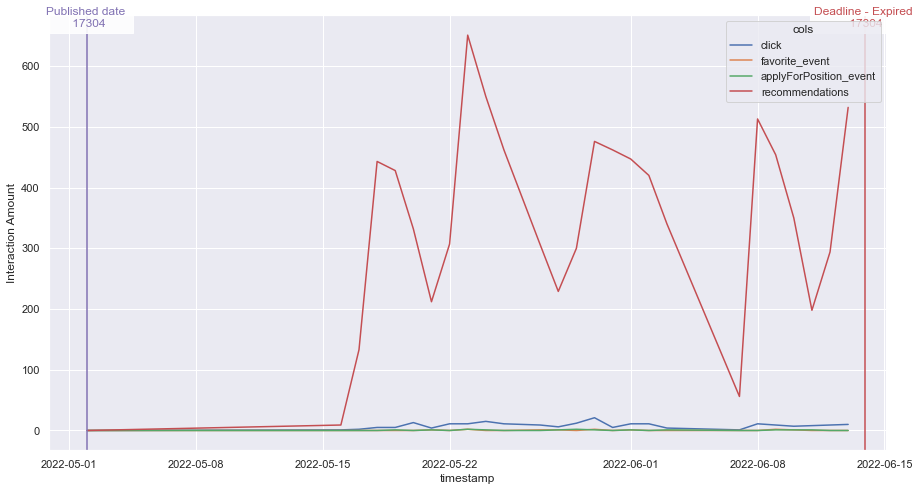

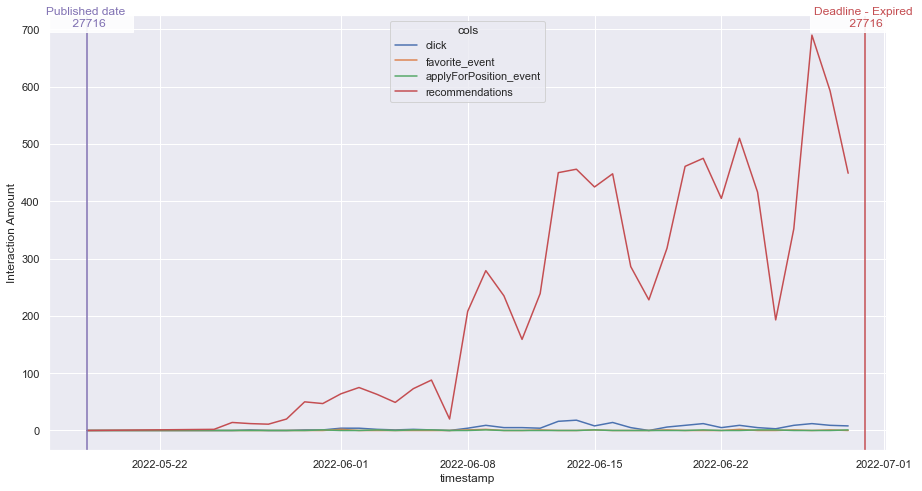

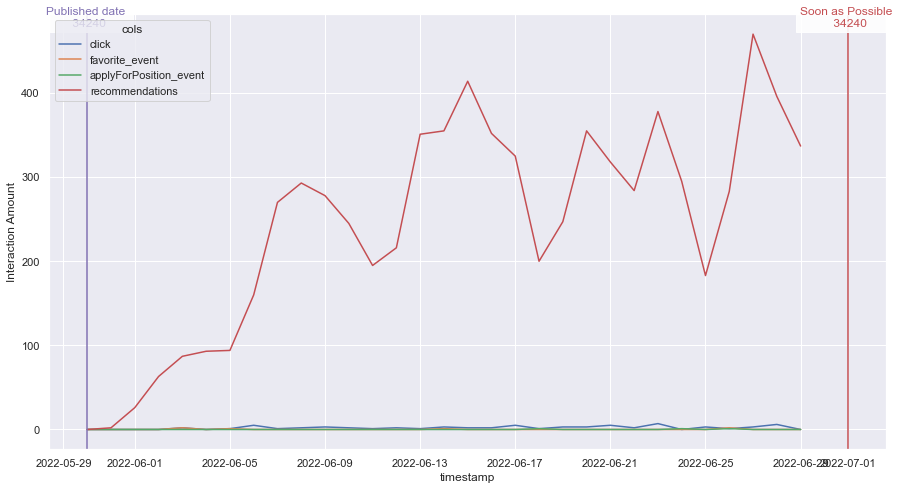

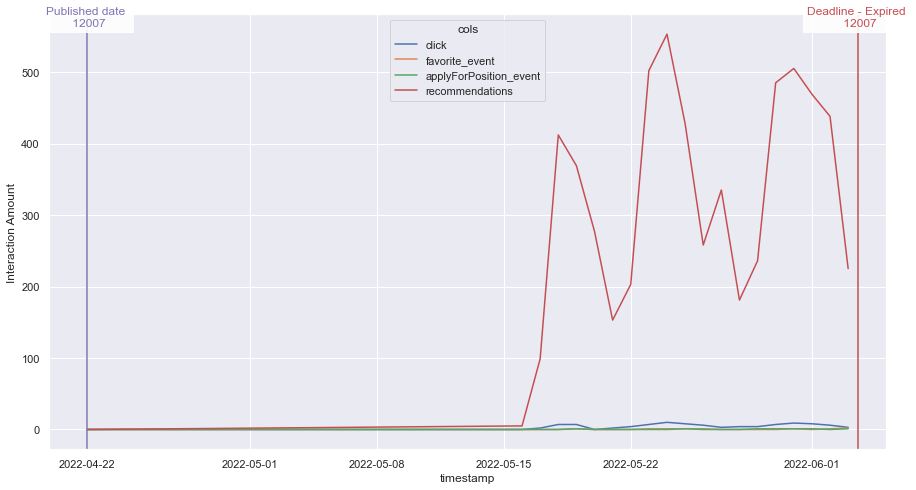

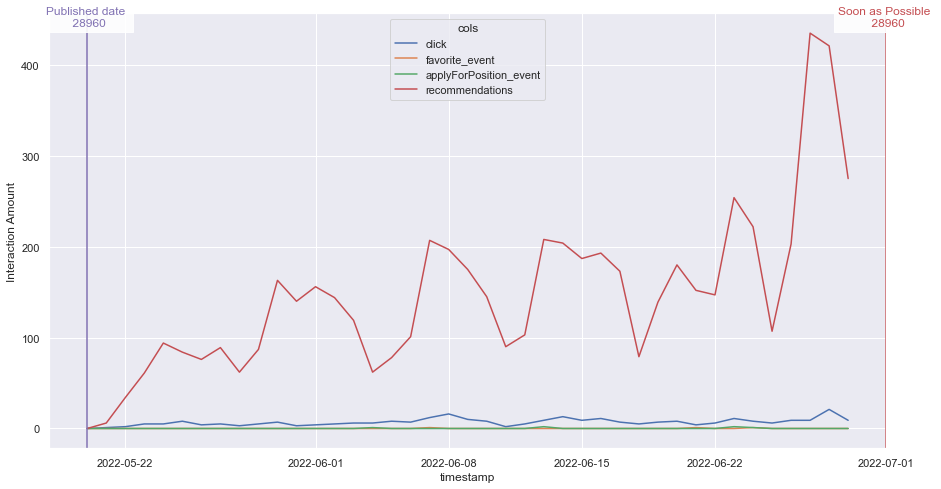

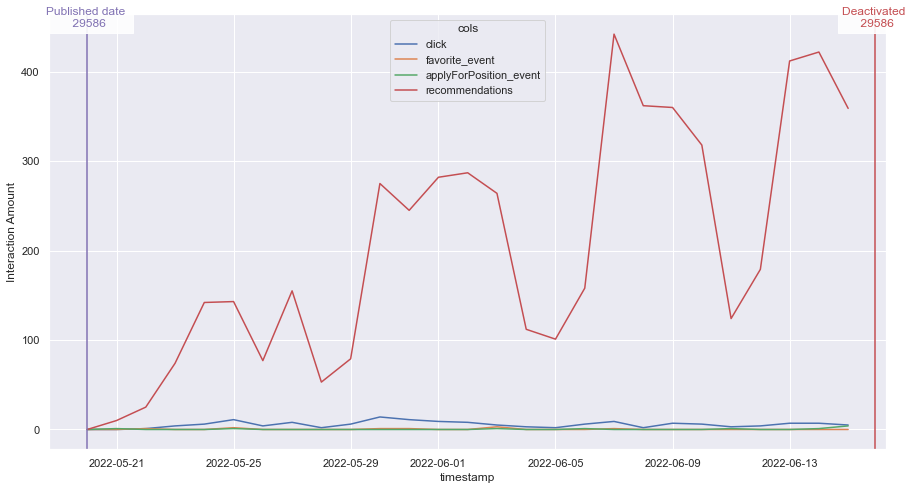

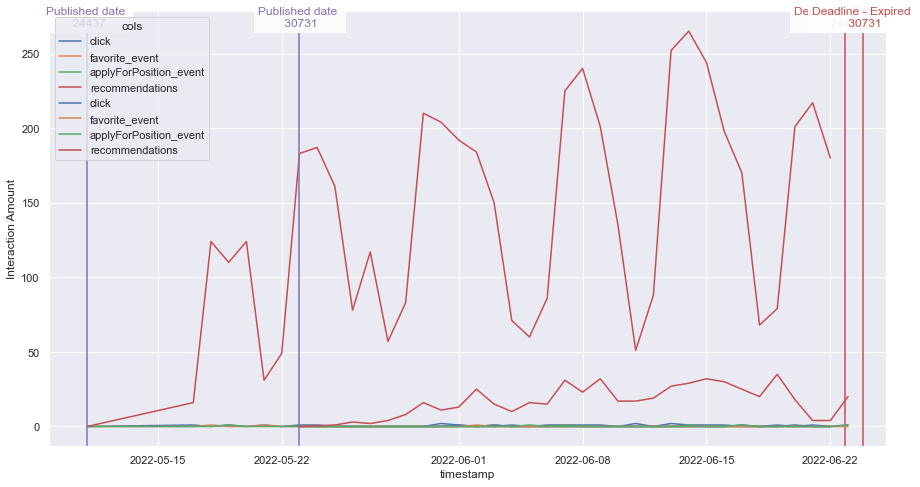

In [10]:
for index, item in enumerate(job_interaction_matrix.sort_values(by='recommendations', ascending=False).head(10).itemId):
    plt.figure(index)
    get_time_interaction_graph_for_item(item)
# %%

# %%
#TODO
#- sjekke private vs offentlig
#- Se mer på deadlines
#- Se på expiration


graph, times = get_time_interaction_graph_for_item(30731)
graph.figure.savefig('./figs/soon-as-possible-job.png')

In [ ]:
graph, times = get_time_interaction_graph_for_item(15129)
graph.figure.savefig('./figs/deadline-expired.png')
# %%

graph, times = get_time_interaction_graph_for_item(35136)
graph.figure.savefig('./figs/deadline.png')
# %%

# %%

# %%
interactions_events[interactions_events.userId.isin(rating_matrix[rating_matrix.iidx.isin(item_feature_df[item_feature_df.feature == 'short_head'].iidx)].userId)]
# %%